In [1]:
#容量制約付き有向最小機問題
import networkx as nx
import matplotlib.pyplot as plt
from mypulp import Model, quicksum, GRB
from collections import OrderedDict, defaultdict

In [4]:
with open("../input/capmst/capmst1.txt") as f:
    lines = f.readlines()
n_line = 0

n_line = 0
for iter_ in range(20):
    prob = lines[n_line]
    n_line += 1
    n = int(lines[n_line])  # number of nodes
    G = nx.DiGraph()
    n_line += 1
    for i in range(n + 1):
        array = []
        while 1:
            line = lines[n_line].split()
            array.extend(line)
            if len(array) >= n + 1:
                break
            n_line += 1
        for j, cost in enumerate(array):
            if i != j:
                G.add_edge(i, j, weight=int(cost))
        n_line += 1
    n_line += 1
    nx.write_weighted_edgelist(G, "../input/capmst/" + prob[:-6].strip() + ".txt")

In [5]:
fname = "../input/capmst/tc40-1.txt"
G = nx.read_weighted_edgelist(fname, create_using=nx.DiGraph, nodetype=int)
n = len(G)

# Q=3, 5, or 10 for n=40
# Q=5, 10, or 20 for n=80

Q = 10
print("n=", n, "Q=", Q)

n= 41 Q= 10


In [6]:
model = Model()
x, y = {}, {}
for (i, j) in G.edges():
    if i != j and j != n - 1:  # ルートであるn-1に入る枝はない
        x[i, j] = model.addVar(vtype="B", name=f"x[{i},{j}]")
        y[i, j] = model.addVar(vtype="C", name=f"y[{i},{j}]")
model.update()

model.addConstr(quicksum(x[i, j] for (i, j) in x) == n - 1)

for j in range(0, n - 1):  # ルート以外の点は入次数が1
    model.addConstr(
        quicksum(x[i, j] for i in range(n) if i != j) == 1, name=f"in_degree[{j}]"
    )
for j in range(0, n - 1):  # ルート以外の点に対するフロー保存式
    model.addConstr(
        quicksum(y[i, j] for i in range(n) if i != j)
        - quicksum(y[j, i] for i in range(0, n - 1) if i != j)
        == 1,
        name=f"flow_conservarion[{j}]",
    )
for i in range(n):
    for j in range(0, n - 1):
        if i != j:
            model.addConstr(x[i, j] <= y[i, j], name=f"lower_bound[{i},{j}]")
            if i == n - 1:  # ルートに入るフロー量はQ以下
                model.addConstr(y[i, j] <= Q * x[i, j], name=f"upper_bound[{i},{j}]")
            else:  # ルート以外の点に入るフロー量はQ-1以下
                model.addConstr(
                    y[i, j] <= (Q - 1) * x[i, j], name=f"upper_bound[{i},{j}]"
                )
model.setObjective(quicksum(G[i][j]["weight"] * x[i, j] for (i, j) in x), GRB.MINIMIZE)
model.optimize()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/penguin/.conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d54cfe0ee13148c9ba218df98e1f1238-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/d54cfe0ee13148c9ba218df98e1f1238-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3286 COLUMNS
At line 20847 RHS
At line 24129 BOUNDS
At line 27330 ENDATA
Problem MODEL has 3281 rows, 3200 columns and 12760 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 469.178 - 0.04 seconds
Cgl0005I 40 SOS with 1600 members
Cgl0004I processed model has 3241 rows, 3160 columns (1600 integer (1600 of which binary)) and 15760 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 33 integers unsatisfied sum - 9.30582
Cbc0038I Pass   1: (0.11 seconds) suminf.    4.80000 (16) obj. 542.3 iterations 60

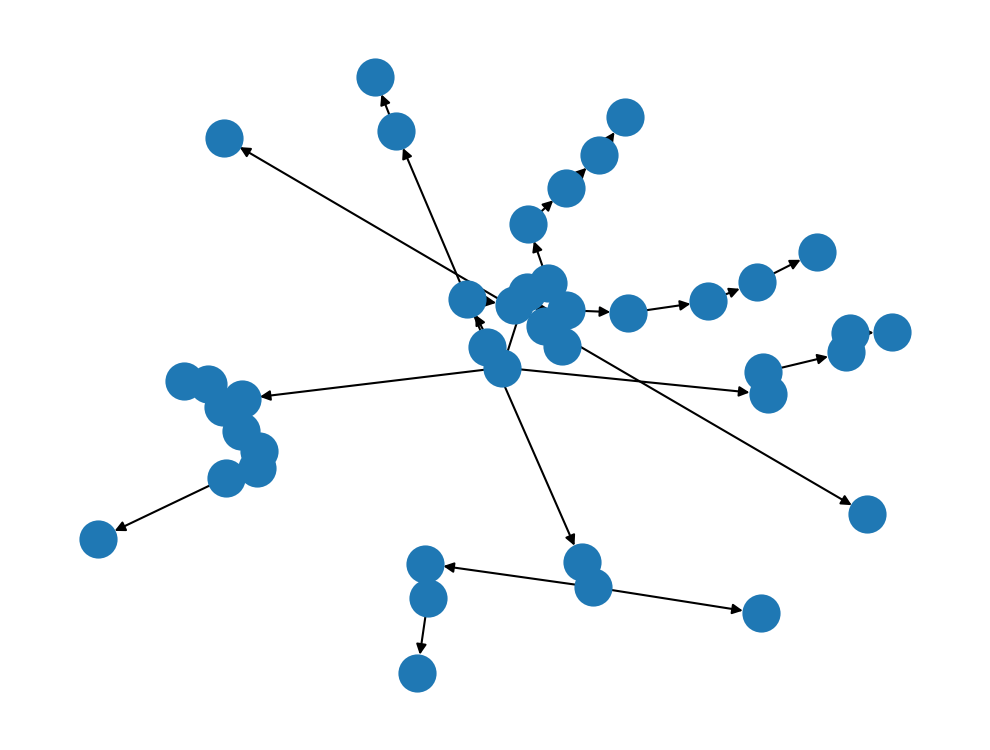

In [7]:
SolGraph = nx.DiGraph()
for (i, j) in x:
    if x[i, j].X > 0.1:
        SolGraph.add_edge(i, j)
nx.draw(SolGraph)